In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import SMOTE
import scorecardpy as sc
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

from src.preprocessing import load_data, impute_missing_values, encode_categorical_features, scale_features, balance_data
from src.eda import basic_statistics, plot_distributions, plot_categorical_counts

# Load train and test datasets
train_df = pd.read_csv('../data/train.csv')
test_df = pd.read_csv('../data/test.csv')
test_df_original = test_df.copy()

print(f"Train dataset shape: {train_df.shape}")
print(f"Test dataset shape: {test_df.shape}")

# Quick preview of the data
train_df.head()

Train dataset shape: (45528, 19)
Test dataset shape: (11383, 18)


,customer_id,name,age,gender,owns_car,owns_house,no_of_children,net_yearly_income,no_of_days_employed,occupation_type,total_family_members,migrant_worker,yearly_debt_payments,credit_limit,credit_limit_used(%),credit_score,prev_defaults,default_in_last_6months,credit_card_default
0,CST_115179,ita Bose,46,F,N,Y,0.0,107934.04,612.0,Unknown,1.0,1.0,33070.28,18690.93,73,544.0,2,1,1
1,CST_121920,Alper Jonathan,29,M,N,Y,0.0,109862.62,2771.0,Laborers,2.0,0.0,15329.53,37745.19,52,857.0,0,0,0
2,CST_109330,Umesh Desai,37,M,N,Y,0.0,230153.17,204.0,Laborers,2.0,0.0,48416.60,41598.36,43,650.0,0,0,0
3,CST_128288,Rie,39,F,N,Y,0.0,122325.82,11941.0,Core staff,2.0,0.0,22574.36,32627.76,20,754.0,0,0,0
4,CST_151355,McCool,46,M,Y,Y,0.0,387286.00,1459.0,Core staff,1.0,0.0,38282.95,52950.64,75,927.0,0,0,0


In [2]:
# Check missing values in train and test datasets
print("\nMissing values in train dataset:")
print(train_df.isnull().sum().sort_values(ascending=False).head(10))

print("\nMissing values in test dataset:")
print(test_df.isnull().sum().sort_values(ascending=False).head(10))

# Check data types
print("\nData types in train dataset:")
print(train_df.dtypes)

# Check class imbalance in the target variable
print("\nClass distribution in train dataset:")
print(train_df['credit_card_default'].value_counts(normalize=True))



Missing values in train dataset:
no_of_children             774
owns_car                   547
no_of_days_employed        463
yearly_debt_payments        95
migrant_worker              87
total_family_members        83
credit_score                 8
customer_id                  0
default_in_last_6months      0
prev_defaults                0
dtype: int64

Missing values in test dataset:
no_of_children          190
owns_car                132
no_of_days_employed     105
total_family_members     31
migrant_worker           26
yearly_debt_payments     22
credit_score              3
customer_id               0
prev_defaults             0
credit_limit_used(%)      0
dtype: int64

Data types in train dataset:
customer_id                 object
name                        object
age                          int64
gender                      object
owns_car                    object
owns_house                  object
no_of_children             float64
net_yearly_income          float64
no_of_d

In [3]:
from src.preprocessing import impute_missing_values

# Separate categorical and numerical features
# Define categorical and numerical features based on train dataset
cat_feats = [col for col in train_df.columns if train_df[col].dtype == 'object']
num_feats = [col for col in train_df.columns if train_df[col].dtype != 'object' and col != 'credit_card_default']

# Impute missing values in train and test datasets
train_df = impute_missing_values(train_df, cat_feats, num_feats)
test_df = impute_missing_values(test_df, cat_feats, num_feats)

print("Missing values after imputation (train):")
print(train_df.isnull().sum().sort_values(ascending=False).head())

print("Missing values after imputation (test):")
print(test_df.isnull().sum().sort_values(ascending=False).head())


Missing values after imputation (train):
customer_id                0
total_family_members       0
default_in_last_6months    0
prev_defaults              0
credit_score               0
dtype: int64
Missing values after imputation (test):
customer_id             0
name                    0
prev_defaults           0
credit_score            0
credit_limit_used(%)    0
dtype: int64


/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/preprocessing.py:39: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(mode_val, inplace=True)
/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/preprocessing.py:44: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always beh

In [4]:
# Drop unnecessary text columns (customer_id, name)
train_df = train_df.drop(columns=['customer_id', 'name'])
test_df = test_df.drop(columns=['customer_id', 'name'])

print(f"Remaining columns after dropping text columns (train): {train_df.columns.tolist()}")
print(f"Remaining columns after dropping text columns (test): {test_df.columns.tolist()}")


Remaining columns after dropping text columns (train): ['age', 'gender', 'owns_car', 'owns_house', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'occupation_type', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months', 'credit_card_default']
Remaining columns after dropping text columns (test): ['age', 'gender', 'owns_car', 'owns_house', 'no_of_children', 'net_yearly_income', 'no_of_days_employed', 'occupation_type', 'total_family_members', 'migrant_worker', 'yearly_debt_payments', 'credit_limit', 'credit_limit_used(%)', 'credit_score', 'prev_defaults', 'default_in_last_6months']


In [5]:
from src.feature_engineering import compute_iv

# Define target variable
target = 'credit_card_default'

# Compute IV and drop low-IV columns from train dataset
train_df, iv_df = compute_iv(train_df, target, threshold=0.02)

# Get the remaining columns after IV filtering (excluding the target column)
selected_features = train_df.drop(columns=[target]).columns.tolist()

# Apply the same feature selection to the test dataset
test_df = test_df[selected_features]

print(f"Shape of train dataset after IV filtering: {train_df.shape}")
print(f"Shape of test dataset after IV filtering: {test_df.shape}")


print(f"Remaining columns after IV filtering (train): {selected_features}")


/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/feature_engineering.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d2 = d1.groupby("Bucket", as_index=True)
/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/feature_engineering.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d2 = d1.groupby("Bucket", as_index=True)
/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/feature_engineering.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or obse

Selected 5 features with IV >= 0.02
Shape of train dataset after IV filtering: (45528, 6)
Shape of test dataset after IV filtering: (11383, 5)
Remaining columns after IV filtering (train): ['credit_score', 'credit_limit_used(%)', 'no_of_days_employed', 'occupation_type', 'gender']


/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/feature_engineering.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d2 = d1.groupby("Bucket", as_index=True)
/Users/shubhupadhyay/Desktop/Projects/Credit Risk Analysis/src/feature_engineering.py:45: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  d2 = d1.groupby("Bucket", as_index=True)
/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/shubhupadhyay/Desktop/Projects/Credit Risk Ana

In [6]:
import scorecardpy as sc

# Apply WOE binning on train dataset
bins = sc.woebin(train_df, y=target)
train_woe_df = sc.woebin_ply(train_df, bins)

# Apply WOE binning on test dataset using the same bins
test_woe_df = sc.woebin_ply(test_df, bins)

print(f"Shape of train dataset after WOE binning: {train_woe_df.shape}")
print(f"Shape of test dataset after WOE binning: {test_woe_df.shape}")


[INFO] creating woe binning ...


/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_datetime without passing `errors` and catch exceptions explicitly instead
  datetime_cols = dat.apply(pd.to_numeric,errors='ignore').select_dtypes(object).apply(pd.to_datetime,errors='ignore').select_dtypes('datetime64').columns.tolist()
/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/scorecardpy/condition_fun.py:40: UserWarning: Could not

[INFO] converting into woe values ...
[INFO] converting into woe values ...
Shape of train dataset after WOE binning: (45528, 6)
Shape of test dataset after WOE binning: (11383, 5)


In [7]:
# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale train features (excluding target)
X_train = scaler.fit_transform(train_woe_df.drop(columns=[target]))
y_train = train_woe_df[target]

# Scale test features
X_test = scaler.transform(test_woe_df)

print(f"Shape of scaled X_train: {X_train.shape}")
print(f"Shape of scaled X_test: {X_test.shape}")


Shape of scaled X_train: (45528, 5)
Shape of scaled X_test: (11383, 5)


In [8]:
# Apply SMOTE to handle class imbalance
sm = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = sm.fit_resample(X_train, y_train)

print(f"Shape of balanced X_train: {X_train_balanced.shape}")
print(f"Class distribution after SMOTE:\n{y_train_balanced.value_counts()}")


Shape of balanced X_train: (83662, 5)
Class distribution after SMOTE:
credit_card_default
1    41831
0    41831
Name: count, dtype: int64


In [9]:
from sklearn.model_selection import train_test_split

# Split train dataset into 80% train and 20% validation
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X_train_balanced, y_train_balanced, test_size=0.2, random_state=42, stratify=y_train_balanced
)

print(f"Shape of X_train_final: {X_train_final.shape}")
print(f"Shape of X_val: {X_val.shape}")


Shape of X_train_final: (66929, 5)
Shape of X_val: (16733, 5)


In [12]:
from src.modeling import evaluate_model
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, roc_auc_score

# Train models and collect metrics
models_metrics = {}

# Logistic Regression
logreg = LogisticRegression(random_state=42, max_iter=1000)
metrics_logreg = evaluate_model(logreg, X_train_final, y_train_final, X_val, y_val)
models_metrics["Logistic Regression"] = metrics_logreg




Confusion Matrix (Test Data):
[[7777  590]
 [ 341 8025]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.96      0.93      0.94      8367
           1       0.93      0.96      0.95      8366

    accuracy                           0.94     16733
   macro avg       0.94      0.94      0.94     16733
weighted avg       0.94      0.94      0.94     16733



In [13]:
# Decision Tree
tree = DecisionTreeClassifier(random_state=42)
metrics_tree = evaluate_model(tree, X_train_final, y_train_final, X_val, y_val)
models_metrics["Decision Tree"] = metrics_tree



Confusion Matrix (Test Data):
[[7873  494]
 [ 236 8130]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8367
           1       0.94      0.97      0.96      8366

    accuracy                           0.96     16733
   macro avg       0.96      0.96      0.96     16733
weighted avg       0.96      0.96      0.96     16733



In [14]:

# Random Forest
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
metrics_rf = evaluate_model(rf, X_train_final, y_train_final, X_val, y_val)
models_metrics["Random Forest"] = metrics_rf



Confusion Matrix (Test Data):
[[7867  500]
 [ 232 8134]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8367
           1       0.94      0.97      0.96      8366

    accuracy                           0.96     16733
   macro avg       0.96      0.96      0.96     16733
weighted avg       0.96      0.96      0.96     16733



In [15]:

# XGBoost
xgb = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric='logloss')
metrics_xgb = evaluate_model(xgb, X_train_final, y_train_final, X_val, y_val)
models_metrics["XGBoost"] = metrics_xgb


/Users/shubhupadhyay/miniconda3/envs/stock_env/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [19:38:32] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1733179641447/work/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Confusion Matrix (Test Data):
[[7845  522]
 [ 235 8131]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.95      8367
           1       0.94      0.97      0.96      8366

    accuracy                           0.95     16733
   macro avg       0.96      0.95      0.95     16733
weighted avg       0.96      0.95      0.95     16733



In [16]:
# CatBoost
catboost = CatBoostClassifier(random_state=42, verbose=0)
metrics_catboost = evaluate_model(catboost, X_train_final, y_train_final, X_val, y_val)
models_metrics["CatBoost"] = metrics_catboost



Confusion Matrix (Test Data):
[[7867  500]
 [ 231 8135]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8367
           1       0.94      0.97      0.96      8366

    accuracy                           0.96     16733
   macro avg       0.96      0.96      0.96     16733
weighted avg       0.96      0.96      0.96     16733



In [17]:

# LightGBM
lgbm = LGBMClassifier(random_state=42)
metrics_lgbm = evaluate_model(lgbm, X_train_final, y_train_final, X_val, y_val)
models_metrics["LightGBM"] = metrics_lgbm


[LightGBM] [Info] Number of positive: 33465, number of negative: 33464
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000713 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 584
[LightGBM] [Info] Number of data points in the train set: 66929, number of used features: 5
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500007 -> initscore=0.000030
[LightGBM] [Info] Start training from score 0.000030

Confusion Matrix (Test Data):
[[7898  469]
 [ 263 8103]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8367
           1       0.95      0.97      0.96      8366

    accuracy                           0.96     16733
   macro avg       0.96      0.96      0.96     16733
weighted avg       0.96      0.96      0.96     16733



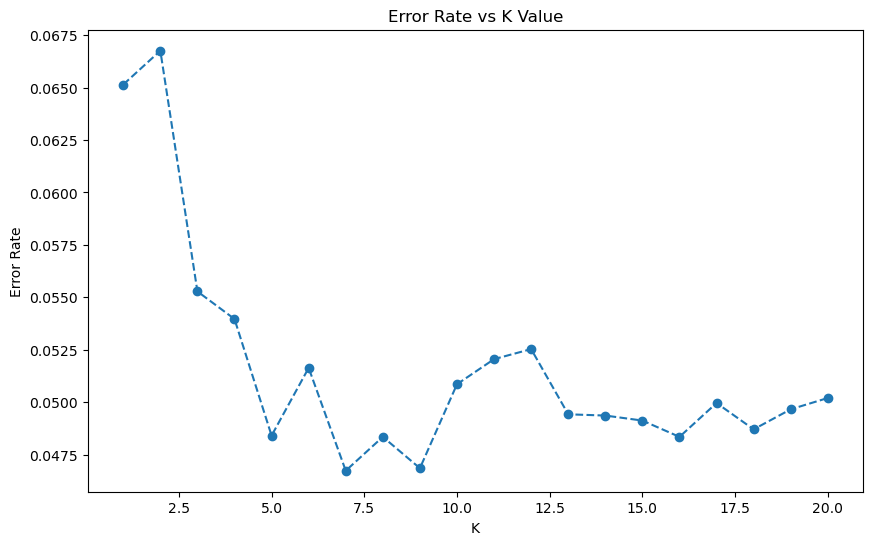

In [19]:
error_rate = []

# Iterate over k values from 1 to 20
for k in range(1, 21):
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_final, y_train_final)  # Use train split for training
    pred_k = knn.predict(X_val)  # Use validation split for predictions
    error_rate.append(np.mean(pred_k != y_val))  # Calculate error rate on validation set

# Plot error rate vs k
plt.figure(figsize=(10, 6))
plt.plot(range(1, 21), error_rate, marker='o', linestyle='dashed')
plt.title('Error Rate vs K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')
plt.show()


In [20]:

# K-Nearest Neighbors (k=5)
knn = KNeighborsClassifier(n_neighbors=5)
metrics_knn = evaluate_model(knn, X_train_final, y_train_final, X_val, y_val)
models_metrics["KNN"] = metrics_knn



Confusion Matrix (Test Data):
[[7883  484]
 [ 326 8040]]

Classification Report (Test Data):
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      8367
           1       0.94      0.96      0.95      8366

    accuracy                           0.95     16733
   macro avg       0.95      0.95      0.95     16733
weighted avg       0.95      0.95      0.95     16733



In [21]:


# Create a comparison dictionary
models_metrics = {
    "Logistic Regression": metrics_logreg,
    "Decision Tree": metrics_tree,
    "Random Forest": metrics_rf,
    "XGBoost": metrics_xgb,
    "CatBoost": metrics_catboost,
    "LightGBM": metrics_lgbm,
    "KNN": metrics_knn
}

# Convert to DataFrame for better visualization
comparison_df = pd.DataFrame(models_metrics).T
print("Model Comparison:")
print(comparison_df.sort_values(by="Test Accuracy", ascending=False))

Model Comparison:
                     Train Accuracy  Test Accuracy  Train F1 Score  \
Decision Tree              0.954011       0.956374        0.954669   
CatBoost                   0.953712       0.956314        0.954416   
Random Forest              0.954011       0.956254        0.954699   
LightGBM                   0.953697       0.956254        0.954241   
XGBoost                    0.952920       0.954760        0.953635   
KNN                        0.950320       0.951593        0.950803   
Logistic Regression        0.942954       0.944361        0.943995   

                     Test F1 Score   AUC-ROC  
Decision Tree             0.957034  0.989764  
CatBoost                  0.957003  0.990506  
Random Forest             0.956941  0.989971  
LightGBM                  0.956784  0.990357  
XGBoost                   0.955520  0.990291  
KNN                       0.952043  0.982720  
Logistic Regression       0.945174  0.987844  


In [22]:
from src.modeling import rank_models
# Rank models using AUC-ROC and F1-score with equal weights
best_model_name = rank_models(comparison_df)
best_model_metrics = comparison_df.loc[best_model_name]

print(f"Best Model (based on custom ranking): {best_model_name}")
print(f"Metrics of the Best Model:\n{best_model_metrics}")


Best Model (based on custom ranking): CatBoost
Metrics of the Best Model:
Train Accuracy    0.953712
Test Accuracy     0.956314
Train F1 Score    0.954416
Test F1 Score     0.957003
AUC-ROC           0.990506
Name: CatBoost, dtype: float64


In [23]:
# Initialize and train the best model (CatBoost)
best_model = CatBoostClassifier(random_state=42, verbose=100)
best_model.fit(X_train_balanced, y_train_balanced)

print("CatBoost model trained successfully!")

Learning rate set to 0.068211
0:	learn: 0.5414025	total: 25.2ms	remaining: 25.2s
100:	learn: 0.1188845	total: 763ms	remaining: 6.79s
200:	learn: 0.1163311	total: 1.52s	remaining: 6.05s
300:	learn: 0.1153524	total: 2.22s	remaining: 5.15s
400:	learn: 0.1147542	total: 2.92s	remaining: 4.36s
500:	learn: 0.1145274	total: 3.59s	remaining: 3.58s
600:	learn: 0.1143117	total: 4.25s	remaining: 2.82s
700:	learn: 0.1142053	total: 4.89s	remaining: 2.08s
800:	learn: 0.1141371	total: 5.51s	remaining: 1.37s
900:	learn: 0.1140807	total: 6.12s	remaining: 673ms
999:	learn: 0.1140397	total: 6.71s	remaining: 0us
CatBoost model trained successfully!


In [24]:
# Generate predictions on the test dataset
test_predictions = best_model.predict(X_test)

# Display the first 10 predictions
print("Test Predictions (first 10):", test_predictions[:10])


Test Predictions (first 10): [0 0 1 0 1 0 0 0 0 0]


In [ ]:
# test_df_original is the original test dataset with customer_id before feature engineering
test_predictions_df = pd.DataFrame({
    "customer_id": test_df_original["customer_id"],  # Use customer_id from the original test dataset
    "credit_card_default": test_predictions
})

output_dir = "../reports"
os.makedirs(output_dir, exist_ok=True)  # Create the directory if it doesn't exist

# Export the predictions to CSV
test_predictions_df.to_csv(f"{output_dir}/test_predictions_catboost.csv", index=False)

print(f"Predictions saved to '{output_dir}/test_predictions_catboost.csv'")



Predictions saved to '../reports/test_predictions_catboost.csv'


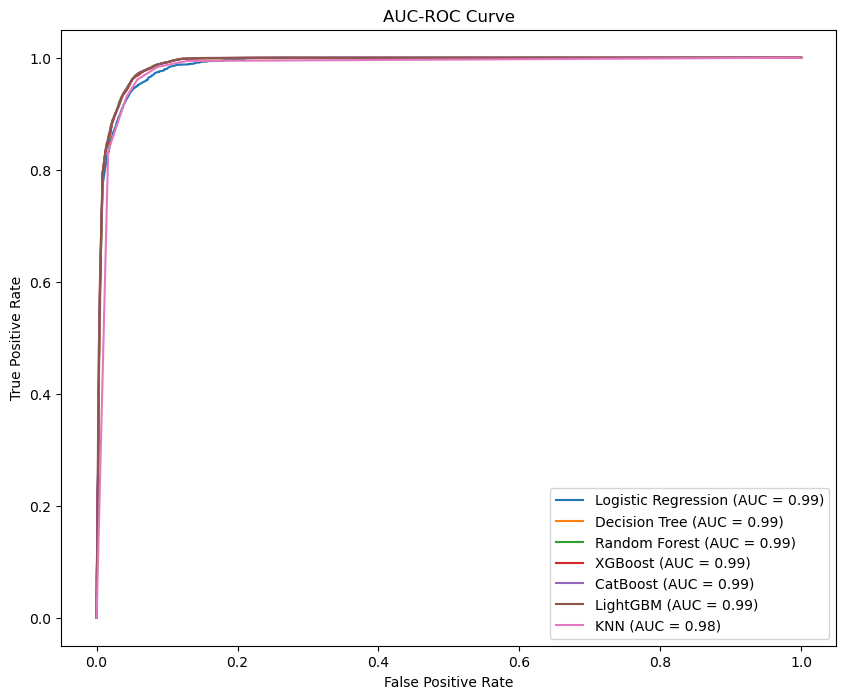

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Function to plot AUC-ROC curve
def plot_roc_curve(model, X, y, label):
    """
    Plots the ROC curve for a given model.
    
    Args:
        model: Trained model.
        X: Feature set.
        y: True labels.
        label: Label for the model.
    """
    y_prob = model.predict_proba(X)[:, 1]
    fpr, tpr, _ = roc_curve(y, y_prob)
    auc = roc_auc_score(y, y_prob)
    
    plt.plot(fpr, tpr, label=f"{label} (AUC = {auc:.2f})")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("AUC-ROC Curve")
    plt.legend(loc="lower right")

# Plot AUC-ROC curves for all models
plt.figure(figsize=(10, 8))

# Logistic Regression
plot_roc_curve(logreg, X_val, y_val, "Logistic Regression")

# Decision Tree
plot_roc_curve(tree, X_val, y_val, "Decision Tree")

# Random Forest
plot_roc_curve(rf, X_val, y_val, "Random Forest")

# XGBoost
plot_roc_curve(xgb, X_val, y_val, "XGBoost")

# CatBoost
plot_roc_curve(catboost, X_val, y_val, "CatBoost")

# LightGBM
plot_roc_curve(lgbm, X_val, y_val, "LightGBM")

# KNN
plot_roc_curve(knn, X_val, y_val, "KNN")

plt.show()


Feature Importances:
                    Feature  Importance
4          credit_score_woe   43.007190
3  credit_limit_used(%)_woe   29.973915
1   no_of_days_employed_woe   12.258758
0                gender_woe    7.571975
2       occupation_type_woe    7.188163


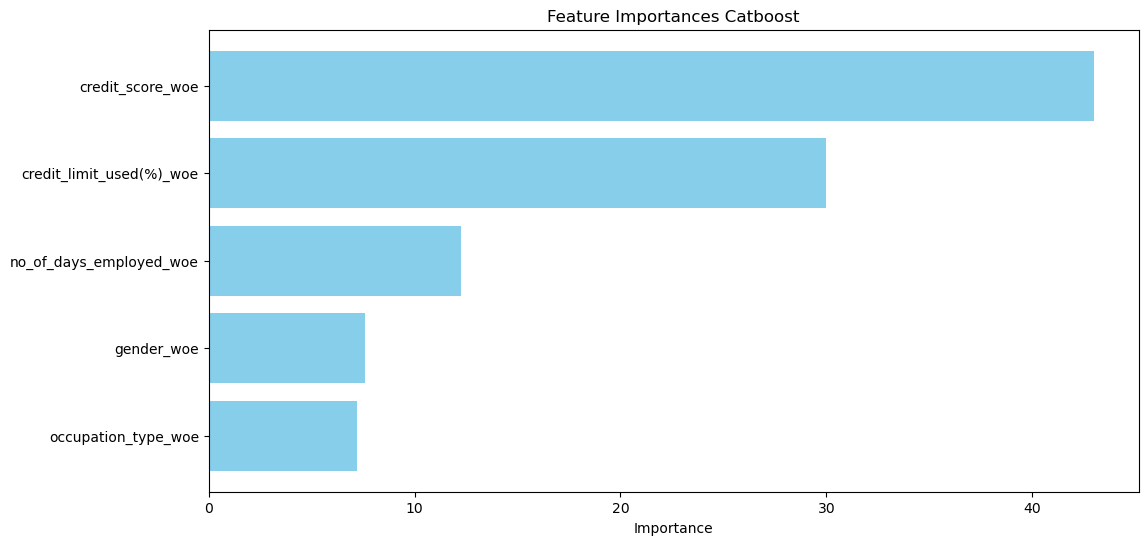

In [30]:
# Get feature importances from the CatBoost model
feature_importances = catboost.feature_importances_
feature_names = train_woe_df.drop(columns=[target]).columns

# Create a DataFrame for feature importances
feature_importance_df = pd.DataFrame({
    "Feature": feature_names,
    "Importance": feature_importances
}).sort_values(by="Importance", ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(12, 6))
plt.barh(feature_importance_df["Feature"], feature_importance_df["Importance"], color='skyblue')
plt.xlabel("Importance")
plt.title("Feature Importances Catboost")
plt.gca().invert_yaxis()
plt.show()


{'gender': <Figure size 640x480 with 2 Axes>,
 'no_of_days_employed': <Figure size 640x480 with 2 Axes>,
 'occupation_type': <Figure size 640x480 with 2 Axes>,
 'credit_limit_used(%)': <Figure size 640x480 with 2 Axes>,
 'credit_score': <Figure size 640x480 with 2 Axes>}

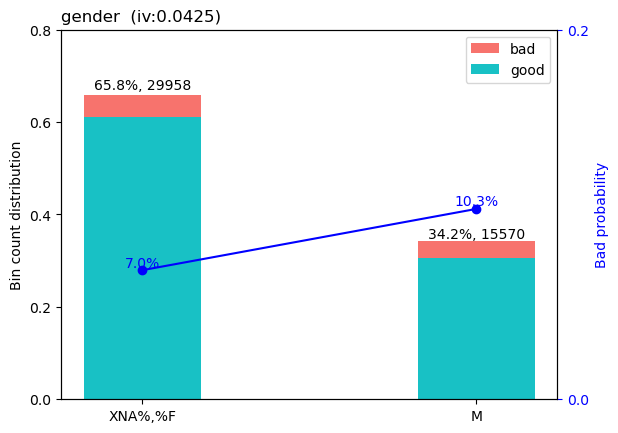

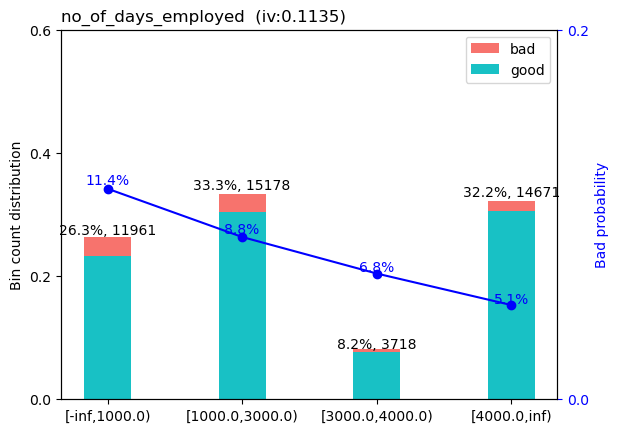

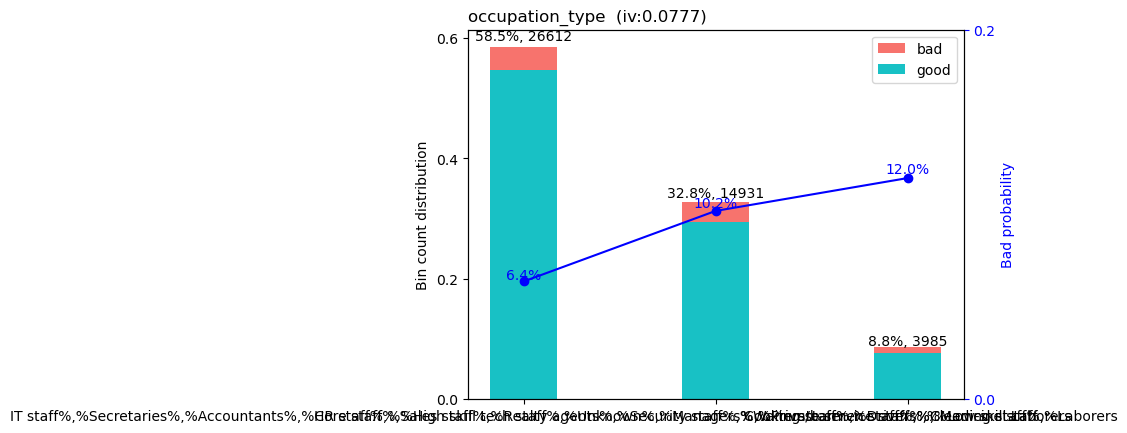

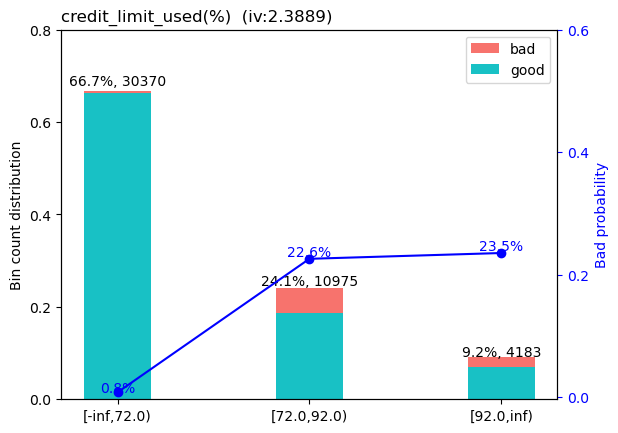

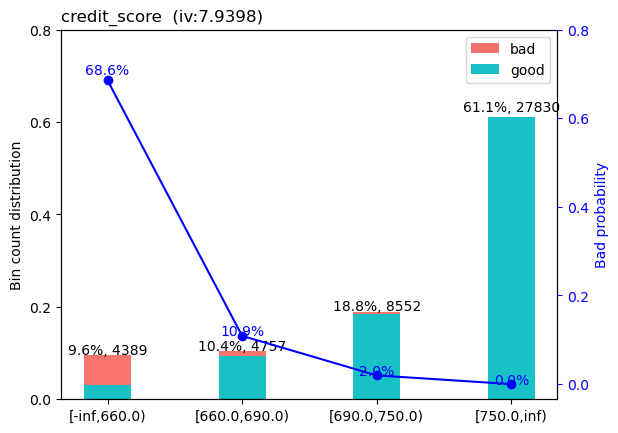

In [29]:
# Plot WOE curves for the bins generated during WOE binning
sc.woebin_plot(bins)
